# Neural Networks

A **neural network** is a data processing pipeline composed of layers, each of which performs a transformation on the input data into a new representation, until it closely resembles the desired output.

**Gradient descent** is the optimization technique that powers neural networks:

* A prediction is made on a training example.

* The **loss function** compares the prediction to the actual target, producing a **loss value**: a measure of how well the model's prediction matches what was expected.

* A **backward pass** computes the gradient of the loss with respect to the model parameters, which describes how the loss varies as you move the model's coefficients in different directions. You can use this gradient to move the coefficients all at once in a direction that decreases the loss.

* The **optimizer** uses the loss value to update the model's weights via the **Backpropagation algorithm**. The optimizer might update the model weights using: learning_rate * gradient (the **learning rate** represents the "speed" of the gradient descent process)

* This process is usually performed in randomly selected batches, so it is called **mini-batch stochastic gradient descent**. Running the process on all the data at once would be more accurate but more expensive.

Tensorflow is capable of autodifferentiation using GradientDescent.

## Example of Autodifferentiation with TensorFlow

In [ ]:
import tensorflow as tf
x = tf.Variable(0.)
with tf.GradientTape() as tape:
    y = 2 * x + 3
grad_of_y_wrt_x = tape.gradient(y, x)

## Naive Implementation of a Neural Network

In [ ]:
# Dense Layer
class NaiveDense:
    def __init__(self, input_size, output_size, activation):
        self.activation = activation

        w_shape = (input_size, output_size)
        w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)
        self.W = tf.Variable(w_initial_value)

        b_shape = (output_size,)
        b_initial_value = tf.zeros(b_shape)
        self.b = tf.Variable(b_initial_value)

    def __call__(self, inputs):
        return self.activation(tf.matmul(inputs, self.W) + self.b)
    
    @property
    def weights(self):
        return [self.W, self.b]

In [ ]:
# Neural Network
class NaiveSequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer(x)
        return x
    
    @property
    def weights(self):
        weights = []
        for layer in self.layers:
            weights += layer.weights
        return weights

In [ ]:
# Optimizer
learning_rate = 1e-3
def update_weights(gradients, weights):
    for g, w in zip(gradients, weights):
        w.assign_sub(g * learning_rate) # equivalent of -= for tensorflow variables

In [ ]:
# Stochastic Gradient Descent (One Step)
def one_training_step(model, images_batch, labels_batch):
    with tf.GradientTape() as tape:

        # Make predictions for all examples in the batch
        predictions = model(images_batch)

        # Compute the losses for all examples in the batch
        per_sample_losses = tf.keras.losses.sparse_categorical_crossentropy(labels_batch, predictions)

        # Get the average loss over all examples in the batch
        average_loss = tf.reduce_mean(per_sample_losses)

    # Compute the gradient of the loss with respect to the model weights
    gradients = tape.gradient(average_loss, model.weights)

    # Update the weights in such a way that will decrease the loss (e.g. learning_rate * gradient)
    update_weights(gradients, model.weights)

    # Return the average loss over all examples in this batch
    return average_loss

In [ ]:
# Batch Generator
import math

class BatchGenerator:

    def __init__(self, images, labels, batch_size=128):
        assert len(images) == len(labels)

        self.index = 0
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.num_batches = math.ceil(len(images) / batch_size)

    def next(self):
        images = self.images[self.index : self.index + self.batch_size]
        labels = self.labels[self.index : self.index + self.batch_size]
        self.index += self.batch_size
        return images, labels

In [ ]:
# Fit (Training)
def fit(model, images, labels, epochs, batch_size=128):

    # For each epoch  (pass through the whole training dataset)
    for epoch_counter in range(epochs):

        print(f"Epoch {epoch_counter}")

        batch_generator = BatchGenerator(images, labels)

        # For each randomly selected batch of training examples
        for batch_counter in range(batch_generator.num_batches):

            images_batch, labels_batch = batch_generator.next()

            # Make predictions (forward pass) and compute the loss
            loss = one_training_step(model, images_batch, labels_batch)

            if batch_counter % 100 == 0:

                print(f"loss at batch {batch_counter}: {loss:.2f}")

## Example of a Neural Network model using the Naive Implementation

In [ ]:
# Example model definition
model = NaiveSequential([
    NaiveDense(input_size=28*28, output_size=512, activation=tf.nn.relu),
    NaiveDense(input_size=512, output_size=10, activation=tf.nn.softmax)
])
assert len(model.weights) == 4

In [ ]:
# Train the example model on the MNIST image dataset
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28*28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28*28))
test_images = test_images.astype("float32") / 255

fit(model, train_images, train_labels, epochs=10, batch_size=128)

In [ ]:
# Evaluation of the example model
import numpy as np
predictions = model(test_images)
predictions = predictions.numpy()
predicted_labels = np.argmax(predictions, axis=1)
matches = predicted_labels == test_labels
print(f"accuracy: {matches.mean():.2f}")

## Example of a Neural Network model using TensorFlow

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Example model definition
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# Train the example model on the MNIST image dataset
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28*28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28*28))
test_images = test_images.astype("float32") / 255
model.fit(train_images, train_labels, epochs=5, batch_size=128)

In [ ]:
# Evaluation of the example model
import numpy as np
predictions = model(test_images)
predictions = predictions.numpy()
predicted_labels = np.argmax(predictions, axis=1)
matches = predicted_labels == test_labels
print(f"accuracy: {matches.mean():.2f}")

## Use Cases

### Classifying movie reviews: A binary classification example

In [2]:
from tensorflow.keras.datasets import imdb
import numpy as np

# Prepare the data
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the model
model = keras.Sequential([
    layers.Dense(16, activation="relu"), # means that W is shape (input_dimension, 16). projects input onto a 16-dim representation space.
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(
    optimizer="rmsprop", # usually a good default choice for virtually any problem
    loss="binary_crossentropy", # crossentropy is usually your best choice when dealing with models that output probability
    metrics=["accuracy"]
)

2023-11-10 16:35:28.950346: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Set asside a validation set
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [6]:
# Train the model
history = model.fit(
    partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val)
)

Epoch 1/20
30/30 [==============================] - 5s 126ms/step - loss: 0.5655 - accuracy: 0.7557 - val_loss: 0.4388 - val_accuracy: 0.8594
Epoch 2/20
30/30 [==============================] - 1s 30ms/step - loss: 0.3520 - accuracy: 0.8899 - val_loss: 0.3415 - val_accuracy: 0.8753
Epoch 3/20
30/30 [==============================] - 1s 22ms/step - loss: 0.2551 - accuracy: 0.9179 - val_loss: 0.2917 - val_accuracy: 0.8851
Epoch 4/20
30/30 [==============================] - 1s 24ms/step - loss: 0.2021 - accuracy: 0.9355 - val_loss: 0.3071 - val_accuracy: 0.8751
Epoch 5/20
30/30 [==============================] - 1s 24ms/step - loss: 0.1684 - accuracy: 0.9471 - val_loss: 0.2780 - val_accuracy: 0.8872
Epoch 6/20
30/30 [==============================] - 1s 34ms/step - loss: 0.1418 - accuracy: 0.9553 - val_loss: 0.2906 - val_accuracy: 0.8831
Epoch 7/20
30/30 [==============================] - 1s 22ms/step - loss: 0.1213 - accuracy: 0.9638 - val_loss: 0.3046 - val_accuracy: 0.8829
Epoch 8/20
3

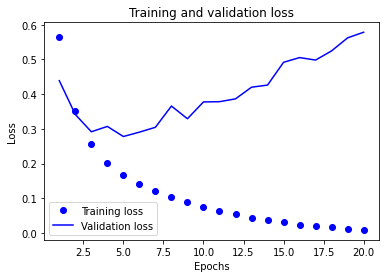

In [8]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


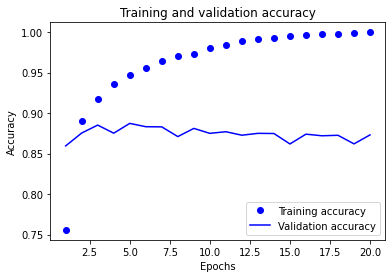

In [9]:
# Plot the training and validation accuracy
history_dict = history.history
loss_values = history_dict["accuracy"]
val_loss_values = history_dict["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training accuracy")
plt.plot(epochs, val_loss_values, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [10]:
# Define a new model from scratch that stops after 5 epochs (when the validation accuracy starts to decrease)
model = keras.Sequential([
    layers.Dense(16, activation="relu"), # means that W is shape (input_dimension, 16). projects input onto a 16-dim representation space.
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(
    optimizer="rmsprop", # usually a good default choice for virtually any problem
    loss="binary_crossentropy", # crossentropy is usually your best choice when dealing with models that output probability
    metrics=["accuracy"]
)
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
results

Epoch 1/4
49/49 [==============================] - 4s 57ms/step - loss: 0.4827 - accuracy: 0.8056
Epoch 2/4
49/49 [==============================] - 1s 22ms/step - loss: 0.2830 - accuracy: 0.9027
Epoch 3/4
49/49 [==============================] - 1s 28ms/step - loss: 0.2195 - accuracy: 0.9204
Epoch 4/4
782/782 [==============================] - 4s 5ms/step - loss: 0.2886 - accuracy: 0.8848


In [12]:
# Use the model! Predict the likelihood of reviews being positive
model.predict(x_test)

782/782 [==============================] - 4s 5ms/step


array([[0.20162888],
       [0.9982227 ],
       [0.8999758 ],
       ...,
       [0.0874413 ],
       [0.090352  ],
       [0.61865216]], dtype=float32)